# Find maximum drop in number density along vector(s) connecting nearest neighbour sites 

In [1]:
!pip install mp_api -q
!pip install mp-pyrho -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 2.7.0 which is incompatible.
spacy 3.4.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 2.7.0 which is incompatible.
gradient-utils 0.5.0 requires pymongo<4.0.0,>=3.11.0, but you have pymongo 4.6.3 which is incompatible.


In [2]:
!pip install jaxlib

You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import jax
# import jax.numpy as jnp

import sys
sys.path.append('/notebooks/ranker/src/')
from api_source import *
from interpolator_and_old_drop_functions import *

from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.analysis.graphs import *
from pymatgen.analysis.local_env import CrystalNN, VoronoiNN, MinimumDistanceNN
from pymatgen.util.coord import find_in_coord_list

import networkx as nx

## Read in dataframe

In [3]:
def convert_to_list(string):
    if string.startswith('[') and string.endswith(']'):
        return eval(string)
    else:
        return string
def convert_string_to_dict(string_dict):
    return eval(string_dict)
main_df = pd.read_csv("df_full_structure.csv", converters={'paper_titles': convert_to_list, "sub_lattice_structure": convert_string_to_dict,
                                                              "lattice_structure": convert_string_to_dict})
main_df.set_index("material_id", inplace=True)
#main_df['sub_lattice_structure'][0]

## Compare new and old single neighbour functions for one mat 
##### old function does not seem to match the 27k saved csv values
##### new functions read in from .npy file and use scipy interpolate

In [4]:
mat_id = 35
scalar_field = np.load("D:/mp-{0}_chgcar_array.npy".format(mat_id))

#print(get_nn_density_drop_old(main_df.loc["mp-{0}".format(mat_id)]))
print(get_nn_density_drop(main_df.loc["mp-{0}".format(mat_id)], scalar_field))

FileNotFoundError: [Errno 2] No such file or directory: 'D:/mp-35_chgcar_array.npy'

In [5]:
#print(Structure.from_dict(main_df["lattice_structure"][10000]).make_supercell([2,2,2]))
#print(Structure.from_dict(main_df["sub_lattice_structure"][10000]))
#Structure.from_dict(main_df["lattice_structure"][10000]).make_supercell([2,2,2]).sites[0].frac_coords
Structure.from_dict(main_df["lattice_structure"][10000]).make_supercell([2,2,2]).lattice.abc

(10.427205647340806, 10.427205647340806, 19.531233876294145)

# Generate shortest nearest neighbor spanning path of the superlattice using pymatgen

In [34]:
def find_path(graph, start_site, end_site, weight_code):
    try:
        path = nx.shortest_path(graph, source=start_site, target=end_site, weight=weight_code)
        return path
    except nx.NetworkXNoPath:
        return None  # No path found
        
def scale_weights(graph):
    """
    ^n the weights of all edges in the graph and rescale
    """
    for u, v, data in graph.edges(data=True):
        if 'weight' in data:
            #print(data['weight'])
            data['weight'] = np.exp(data['weight'])
    return graph

def shortest_atomic_supercell_path(structure, start_index, end_index):
    # initiate neighbour finding algorithm class
    # Neighbour_finder = CrystalNN(weighted_cn=True, search_cutoff= max(structure.lattice.abc)/2, distance_cutoffs=None, 
    #                              x_diff_weight=3.0, porous_adjustment=True)
    #Neighbour_finder = VoronoiNN(cutoff=max(structure.lattice.abc)/2)
    Neighbour_finder = MinimumDistanceNN(tol = 1, cutoff=max(structure.lattice.abc)/2, get_all_sites=True)
    
    # make graph using this neighbor finding algorithm
    graph = StructureGraph.with_local_env_strategy(structure, Neighbour_finder, weights=True)
    
    
    # cube distance weights of edges to penalise 'skipping' sites
    d_weighted_graph = scale_weights(graph.graph)
    print(d_weighted_graph.edges)
    #print(d_weighted_graph.types_and_weights_of_connections)
    path = find_path(d_weighted_graph, start_index, end_index, "weight")
    #nx.draw_spectral(graph.graph)
    if path:
        #print("Path found:", [structure.sites[i].frac_coords for i in path])  # Convert indices to actual sites
        print(path)
        # we must *2 because supercell measures position as a fraction of SCALED unit vectors i.e. (2a),(2b),(2c)
        # but I have set the charge density array to be between 0 and 2 a for each unit vector
        # so we want the site coordinates to lie between 0 and 2* each unit vector
        return [structure.sites[i].frac_coords*2 for i in path]
    
    else:
        # return maximal drop fraction if no suitable weighted connectivity path found
        # I think, as this suggests large separation between unit cells
        return 1
        
#nn_positions = shortest_atomic_supercell_path(main_df["sub_lattice_structure"][10000])
#print(nn_positions)

In [29]:
def form_density_supercell(field):
    # super_field is now a 2x2x2 supercell of the original field
    return np.tile(field, (2,2,2))

# Define a function to return drop in number density between just two sites
def get_single_density_drop(density_field, nn_positions, plot_iter):
    # number density grid points for single unit cell (in terms of a,b,c)
    (x,y,z) = [np.linspace(0,2,density_field.shape[i]) for i in range(3)]
    
    try:
        chg_den_interpolated = interpolate_3d(density_field, nn_positions[0], nn_positions[1], x,y,z, n=40)
    except:
        for i in range(len(nn_positions)):
            for j,val in enumerate(nn_positions[i]):
                if val>1:
                    nn_positions[i][j]=1
        chg_den_interpolated = interpolate_3d(density_field, np.abs(np.array(nn_positions[0])), np.abs(np.array(nn_positions[1])), x,y,z, n=40)
    
    #start_val = max(chg_den_interpolated)
    
    # compare to charge density at beginning or end atomic site
    # if used max, that might take value at a non-sublattice site which we might cross
    #start_val = max(chg_den_interpolated[0], chg_den_interpolated[-1])
    index_zone = 10
    start_val = np.max([chg_den_interpolated[0:index_zone], chg_den_interpolated[-index_zone:]])
    #print(start_val)
    x=np.linspace(0,1,40)
    plt.plot(x+x[-1]*plot_iter, chg_den_interpolated)
    #print(chg_den_interpolated)
    
    return (start_val-min(chg_den_interpolated[index_zone:-index_zone]))/start_val

def get_drops_along_path(row, density_field, sub):
    supercell = Structure.from_dict(row['lattice_structure']).make_supercell([2,2,2])
    sub_struc = Structure.from_dict(row['sub_lattice_structure'])
    mat_ID = row.name

    scaled_start_site_coords = sub_struc.sites[0].frac_coords/2     # scale to supercell basis
    start_index = find_in_coord_list([supercell.sites[i].frac_coords for i in range(len(supercell.sites))], scaled_start_site_coords)[0]
    end_index = find_in_coord_list([supercell.sites[i].frac_coords for i in range(len(supercell.sites))], scaled_start_site_coords+[0.5,0.5,0.5])[0]
    print(start_index, end_index)
    
    if sub:
        # replace supercell with sublattice supercell if want to find only paths
        # between SUB lattice sites
        supercell = sub_struc.make_supercell([2,2,2])
        start_index = find_in_coord_list([supercell.sites[i].frac_coords for i in range(len(supercell.sites))], scaled_start_site_coords)[0]
        end_index = find_in_coord_list([supercell.sites[i].frac_coords for i in range(len(supercell.sites))], scaled_start_site_coords+[0.5,0.5,0.5])[0]
        
    nn_spanning_path = shortest_atomic_supercell_path(supercell, start_index, end_index)

    if nn_spanning_path==1:
        # return maximal drop fraction if no suitable weighted connectivity path found
        # I think, as this suggests large separation between unit cells
        return [1]
        
    drops = np.array([])
    for i in range(len(nn_spanning_path)-1):
        print(nn_spanning_path[i:i+2])
        drops = np.append(drops, get_single_density_drop(density_field, nn_spanning_path[i:i+2], i))
    return drops

In [37]:
Structure.from_dict(main_df.loc["mp-25"]["sub_lattice_structure"]).make_supercell(2,2,2).sites
#print(len(Structure.from_dict(main_df.loc["mp-25"]["sub_lattice_structure"]).make_supercell(2,2,2).sites))

[PeriodicSite: N (0.3192, 0.3192, 0.3192) [0.0287, 0.0287, 0.0287],
 PeriodicSite: N (0.3192, 0.3192, 5.88) [0.0287, 0.0287, 0.5287],
 PeriodicSite: N (0.3192, 5.88, 0.3192) [0.0287, 0.5287, 0.0287],
 PeriodicSite: N (0.3192, 5.88, 5.88) [0.0287, 0.5287, 0.5287],
 PeriodicSite: N (5.88, 0.3192, 0.3192) [0.5287, 0.0287, 0.0287],
 PeriodicSite: N (5.88, 0.3192, 5.88) [0.5287, 0.0287, 0.5287],
 PeriodicSite: N (5.88, 5.88, 0.3192) [0.5287, 0.5287, 0.0287],
 PeriodicSite: N (5.88, 5.88, 5.88) [0.5287, 0.5287, 0.5287],
 PeriodicSite: N (2.461, 5.241, 3.099) [0.2213, 0.4713, 0.2787],
 PeriodicSite: N (2.461, 5.241, 8.66) [0.2213, 0.4713, 0.7787],
 PeriodicSite: N (2.461, 10.8, 3.099) [0.2213, 0.9713, 0.2787],
 PeriodicSite: N (2.461, 10.8, 8.66) [0.2213, 0.9713, 0.7787],
 PeriodicSite: N (8.022, 5.241, 3.099) [0.7213, 0.4713, 0.2787],
 PeriodicSite: N (8.022, 5.241, 8.66) [0.7213, 0.4713, 0.7787],
 PeriodicSite: N (8.022, 10.8, 3.099) [0.7213, 0.9713, 0.2787],
 PeriodicSite: N (8.022, 10.8, 

0 7
[(0, 39, 0), (0, 31, 0), (0, 23, 0), (0, 15, 0), (0, 54, 0), (0, 38, 0), (0, 30, 0), (0, 14, 0), (0, 45, 0), (0, 37, 0), (0, 29, 0), (0, 21, 0), (0, 52, 0), (0, 44, 0), (0, 28, 0), (0, 4, 0), (0, 4, 1), (0, 59, 0), (0, 35, 0), (0, 19, 0), (0, 11, 0), (0, 58, 0), (0, 50, 0), (0, 10, 0), (0, 2, 0), (0, 2, 1), (0, 57, 0), (0, 41, 0), (0, 17, 0), (0, 1, 0), (0, 1, 1), (0, 56, 0), (0, 48, 0), (0, 40, 0), (1, 38, 0), (1, 30, 0), (1, 22, 0), (1, 14, 0), (1, 55, 0), (1, 39, 0), (1, 31, 0), (1, 15, 0), (1, 44, 0), (1, 36, 0), (1, 28, 0), (1, 20, 0), (1, 53, 0), (1, 45, 0), (1, 29, 0), (1, 5, 0), (1, 5, 1), (1, 58, 0), (1, 34, 0), (1, 18, 0), (1, 10, 0), (1, 59, 0), (1, 51, 0), (1, 11, 0), (1, 3, 0), (1, 3, 1), (1, 56, 0), (1, 40, 0), (1, 16, 0), (1, 57, 0), (1, 49, 0), (1, 41, 0), (2, 37, 0), (2, 29, 0), (2, 21, 0), (2, 13, 0), (2, 52, 0), (2, 36, 0), (2, 28, 0), (2, 12, 0), (2, 47, 0), (2, 39, 0), (2, 31, 0), (2, 23, 0), (2, 54, 0), (2, 46, 0), (2, 30, 0), (2, 6, 0), (2, 6, 1), (2, 57, 0),

/tmp/ipykernel_80/788433346.py:26: FutureWarning: with_local_env_strategy is deprecated; use from_local_env_strategy in pymatgen.analysis.graphs instead.
Deprecated on 2024-03-29, to be removed on 2025-03-20.
  graph = StructureGraph.with_local_env_strategy(structure, Neighbour_finder, weights=True)


array([0.99957212, 0.99957622, 0.9995872 ])

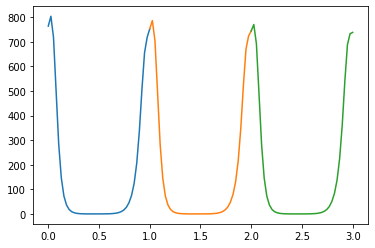

In [35]:
#mat_id = "mp-616821"
mat_id = "mp-25"
#scalar_field = np.load("D:/{0}_chgcar_array.npy".format(mat_id))
scalar_field = np.load("test_density.npy_array_data/{0}_chgcar_array.npy".format(mat_id))

density_supercell = form_density_supercell(scalar_field)
#print(len(density_supercell))

get_drops_along_path(main_df.loc[mat_id], density_supercell, sub=True)  

# Save to csv when ready (need to update to use .npy inputs)

In [ ]:
# Apply the function to create a new column
MAX_MATERIAL_IDS_LENGTH = 1000
material_ids = main_df.index.to_list()

chunks = divide_chunks(material_ids, MAX_MATERIAL_IDS_LENGTH)

# Initialize an empty DataFrame to store drop values
drop_values_df = pd.DataFrame()

for chunk in chunks:
    drop_values = np.ones(len(chunk))*-1
    for i, ID in enumerate(chunk):
        drop_values[i] = get_nn_density_drop(main_df.loc[ID])
    drop_values_df = drop_values_df.append(pd.DataFrame({'Drop Values': drop_values}))

    # Save drop values to CSV file
    drop_values_df.to_csv('drop_values.csv', index=False)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]